https://github.com/uio-ccse/PERC_TopicModel/blob/master/PERC_TopicModeling.ipynb

In [1]:
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('wordnet',quiet=True)
#nltk.download('punkt',quiet=True)   #required by word_tokenize method
nltk.download('averaged_perceptron_tagger',quiet=True) #required by pos_tag method

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

C:\Users\colin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
dfi=pd.read_csv('RapidN_Anonymized210423.csv')
#upload data to dfi
dfq37=dfi['Q37'].copy() #takes single column of the data that is desired
df=dfq37.dropna() #if any rows contain NaN this removes them
data=df.tolist() #takes the responses and puts into list
df=pd.DataFrame(data,columns=['Q37']) #puts back responses to deal with an issue I had of resetting row labels

#if data is saved as a pickle use this code
with open('data_words_bigrams.pkl','rb') as f:
    data_words_bigrams=pickle.load(f)

In [4]:
def sent_to_words(list_sentences):
    return [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in list_sentences]  #deacc=True removes accent marks from tokens (incl. punctuations)
#lowercases, and tokenizes the words
def remove_stopwords(tokens):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS ] for doc in tokens]
#removes the stopwords from each response
def get_wordnet_pos(word): #Provide a POS tag
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) #return NOUN by default

def lemmatize_token(token):
    return nltk.stem.WordNetLemmatizer().lemmatize(token, get_wordnet_pos(token))
#lemmatize means to look for the base word or root, ex: turns read, reading into the same "stem"
def lemmatize(token_list):
    '''Input example: ["he", "matches", "the", "profile"]'''
    return [lemmatize_token(token) for token in token_list]

In [5]:
#Tokenize documents
data_words = sent_to_words(df['Q37'])
#print(data_words)

In [6]:
#Remove stopwords
from gensim.parsing.preprocessing import STOPWORDS
data_words_nostops = remove_stopwords(data_words)
#print(data_words_nostops)

In [7]:
data_words_lemmatized = [lemmatize(token_list) for token_list in data_words_nostops]
#lemmatizes the words after stopwords removed
#print(data_words_lemmatized)

In [8]:
phrases = gensim.models.phrases.Phrases(data_words_lemmatized, min_count=10) #automatically searches for common phrases
bigram = gensim.models.phrases.Phraser(phrases)
#bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(list_tokenized_docs): 
    '''Input example: [['He','matches','the','profile']]'''
    return [bigram[doc] for doc in list_tokenized_docs]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_lemmatized)

Total words: 14567, unique words: 2455


<ipython-input-9-af0598ba3bb3>:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip');


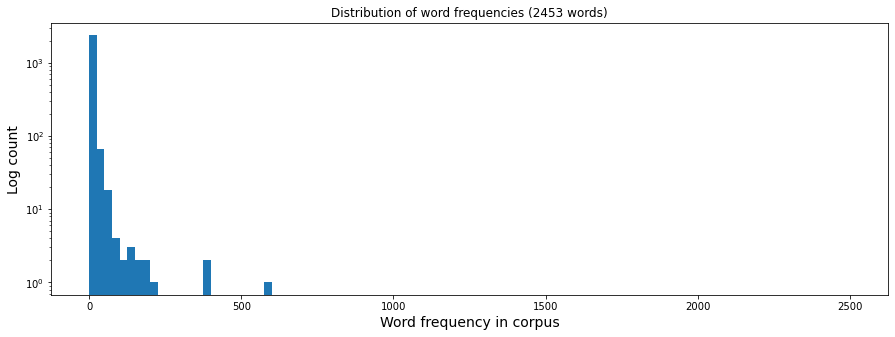

<ipython-input-9-af0598ba3bb3>:41: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', nonposy='clip', );


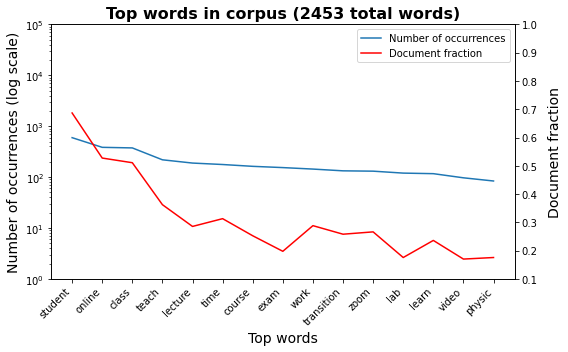

In [9]:
#give a graphical representation of the current words in corpus
def plot_freq_dist(freq_list, **kwargs):
    '''
    Plot distribution of word frequencies
    '''
    fig = plt.subplots(figsize=(15,5))
    _ = plt.hist(freq_list, bins=100, **kwargs);
    _ = plt.title("Distribution of word frequencies ("+str(len(freq_list))+" words)");
    _ = plt.xlabel("Word frequency in corpus", {'fontsize': 14});
    _ = plt.ylabel("Log count", {'fontsize': 14});
    plt.yscale('log', nonposy='clip');
    plt.show();
    return fig

def get_top_n_words(corpus, n_top_words=None):
    '''
    Plot frequency distribution of top n word 
    corpus: list of tokens
    n_top_words: number of most frequent words to plot
    '''
    count_vectorizer = CountVectorizer(stop_words='english')
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx], idx) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return zip(*words_freq[:n_top_words])

def plot_words_freq(word_list, freq_list, n_top_words=20, ylim=None, plot_doc_fraction = False):
    fig, ax = plt.subplots(figsize=(8,5))
    word_len = str(len(word_list))
    freq_list = freq_list[:n_top_words]
    word_list = word_list[:n_top_words]
    ax.plot(range(len(freq_list)), freq_list, label='Number of occurrences');
    ax.set_xticks(range(len(word_list)));
    xticks = list(map(lambda w: str(w), word_list));
    ax.set_xticklabels(xticks, rotation=45, ha='right', fontdict={'fontweight': 'normal'});
    ax.set_title('Top words in corpus (' + word_len + ' total words)', {'fontsize': 16, 'fontweight': 'bold'});
    ax.set_xlabel('Top words', {'fontsize': 14});
    ax.set_ylabel('Number of occurrences (log scale)', {'fontsize': 14});
    ax.set_yscale('log', nonposy='clip', );
    if ylim:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim([10**(np.floor(np.log10(min(freq_list[:n_top_words]))*10)/10), 10**(np.ceil(np.log10(max(freq_list))*10)/10)]);    
    #Fraction
    if plot_doc_fraction:
        frac = [sum([w in temp for temp in data_words_bigrams])/len(data_words_bigrams) for w in words[:n_top_words]]
        ax2 = ax.twinx()
        ax2.plot(range(len(freq_list)), frac, 'r', label='Document fraction');
        ax2.set_ylim([np.floor(min(frac)*10)/10,1])
        ax2.set_ylabel('Document fraction', {'fontsize': 14}, labelpad=10);
        plt.legend(loc='upper left')    
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')    
    plt.tight_layout()
    plt.show();
    return fig, ax

corpus = [ w for doc in data_words_bigrams for w in doc ]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))

[words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
fig = plot_freq_dist(freq, range=[0,2500])
fig, ax = plot_words_freq(words, freq, 15, [1,100000], plot_doc_fraction = True)

Unfiltered Dictionary contains 2455 unique words

Applying no_above=0.30 removes 5 words:
 ['class', 'online', 'student', 'teach', 'time'] 

Filtered Dictionary contains 564 unique words



<ipython-input-9-af0598ba3bb3>:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip');


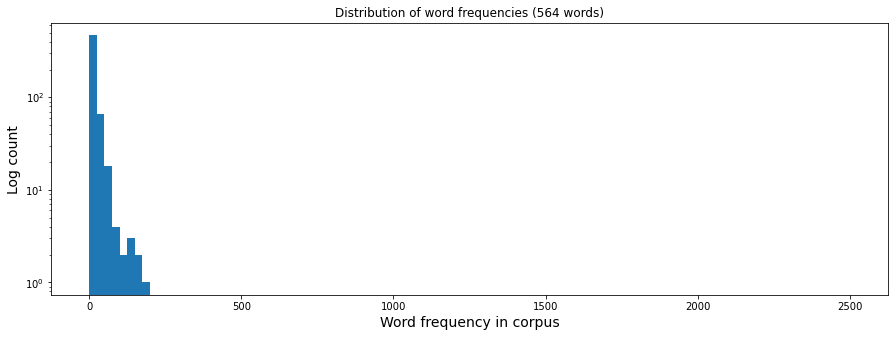

<ipython-input-9-af0598ba3bb3>:41: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', nonposy='clip', );


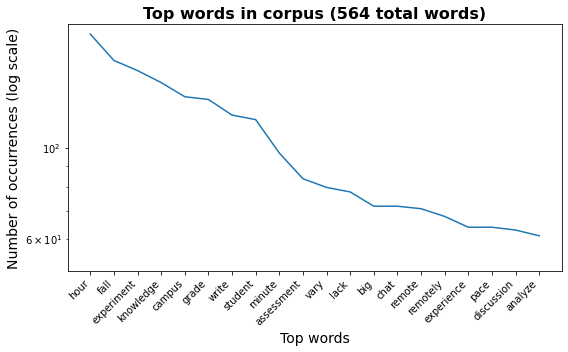

(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Top words in corpus (564 total words)'}, xlabel='Top words', ylabel='Number of occurrences (log scale)'>)

In [10]:
#filter out words that appear in no_above% of the responses
no_below = 5
no_above = 0.30

id2word_unfiltered = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
print("Unfiltered Dictionary contains \033[1m%d\033[0m unique words" % len(id2word_unfiltered))

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=0, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered.values())) - set(list(id2word.values()))
print("\nApplying \033[1mno_above=%.2f removes %d words\033[0m:\n %s \n" % (no_above, len(diff_set), sorted(diff_set)))

id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
print("Filtered Dictionary contains \033[1m%d\033[0m unique words\n" % len(id2word))

#Create BoW
bow_corpus = [id2word.doc2bow(doc) for doc in data_words_bigrams]

#Get most frequent words from id2word Dictionary
#There is a bug with csf: https://github.com/RaRe-Technologies/gensim/issues/2574
[ids, freq] = zip(*sorted(id2word.cfs.items(), key=lambda x: x[1], reverse=True))
words = [id2word_unfiltered[id] for id in ids]  #have to use id2word_unfiltered to retrieve words from ids!!
# Plot distribution
plot_freq_dist(freq, range=[0,2500])
plot_words_freq(words, freq, 20, ylim=None)

In [11]:
#apply the LDA model to the bag of words created in cell above
num_topics = 5 #can be estimated or searched for (see further)
alphatot = 40 #unsure of how to maximize this hyperparameter without doing searching
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus, 
                                   id2word=id2word, 
                                   num_topics=num_topics,
                                   alpha=[alphatot/num_topics] * num_topics,
                                   random_state=430,
                                   iterations=15, passes=50)                 

lda_model.show_topics(num_words=6, formatted=True) #displace top 6 words in each topic

[(0,
  '0.040*"lecture" + 0.025*"zoom" + 0.024*"course" + 0.021*"transition" + 0.018*"work" + 0.014*"homework"'),
 (1,
  '0.037*"exam" + 0.019*"transition" + 0.017*"learn" + 0.016*"course" + 0.016*"work" + 0.014*"problem"'),
 (2,
  '0.015*"face_face" + 0.015*"course" + 0.014*"content" + 0.013*"fall" + 0.012*"lecture" + 0.012*"work"'),
 (3,
  '0.028*"week" + 0.020*"lecture" + 0.016*"video" + 0.014*"learn" + 0.013*"course" + 0.012*"lab"'),
 (4,
  '0.024*"lab" + 0.016*"work" + 0.015*"group" + 0.014*"exam" + 0.014*"think" + 0.013*"question"')]

In [12]:
#Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score. Higher the better
coherence_lda = gensim.models.CoherenceModel(model=lda_model, 
                                             texts=data_words_bigrams, 
                                             dictionary=id2word, 
                                             coherence='c_v',
                                             topn=20).get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.308433029778755

Coherence Score:  0.3867911164106036


In [13]:
#creates a PCA analysis type display of the topics and the words that fit in each topic
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word) 
pyLDAvis.display(vis)

In [14]:
def get_weight_in_doc(ldamodel, corpus, doc_num, fill=0):
    """ Get the weigth for each topic in a document
    Inputs: ldamodel, corpus, doc_num, fill (value when topic was not found)
    Output: list of tuples [(<topic number>, <topic weight>)]
    """
    num_topics = ldamodel.num_topics
    weights = [fill] * num_topics
    # Get a list of tuples with the detected topics and weights
    row = ldamodel[corpus][doc_num]
    # Process the output to return a list of weights
    tw = list(zip(*row))
    for topic in range(num_topics):
        if topic in tw[0]:
            ind = tw[0].index(topic)
            weights[topic] = tw[1][ind]
    return weights

def get_weight_per_doc(ldamodel, corpus):
    """ Get a document by topic weight Dataframe 
    Inputs: ldamodel, corpus
    """
    num_topics = ldamodel.num_topics
    dataframe = pd.DataFrame(np.zeros((len(corpus),num_topics)), columns=list(range(num_topics)))
    dataframe.index.name = 'Topic weights'
    for i, row in dataframe.iterrows():
        dataframe.iloc[i] = pd.Series(get_weight_in_doc(ldamodel, corpus, i))
    return dataframe

weights = get_weight_per_doc(lda_model, bow_corpus)

In [15]:
df=pd.concat([df,weights],axis=1) #adds the breakdown of each response into the different topics

In [16]:
df.nlargest(3,[0]) #shows the 3 responses with the highest correlation to topic [] 

,Q37,0,1,2,3,4
338,I basically took my in-person lecture and lect...,0.678706,0.082087,0.101550,0.073110,0.064546
75,"I happened to be team teaching, my colleague a...",0.639570,0.111037,0.070944,0.094735,0.083714
42,"I am a physics teaching assistant, so the cour...",0.609197,0.095120,0.097606,0.103411,0.094667


In [18]:
print(df[338])

KeyError: 338